## 🗺 План

<ol start=0>
    
<li><a href="#1">Описание задачи.</a></li>
<li><a href="#2">Генерация и фильтрация признаков.</a></li>
<li><a href="#3">Учимся прогнозировать время и вид поломки машин - настраиваем ML модель.</a></li>
<li><a href="#4">Визуализация прогнозов, ошибок модели и важности признаков.</a></li>
<li><a href="#5">Оптимизация</a></li>
<li><a href="#6">Блендинг</a></li>
    
</ol>

## 🚗 Описание задачи

**Предыстория:**

- Мы работаем с каршеринговой компанией, управляющей крупным автопарком машин.
- Цель: предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт. 

**Идея для решения проблемы:**

- Создание приоритезированного списка обхода машин. 
- Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.

**Как будем решать?:**

- Компания собирает данные о поездках и состоянии машин до поломок. 
- Компания наняла Data Scientist'а, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**

- Роль этого специалиста (Data Scientist) будешь играть ты! 😎

## <center> 🔎 Знакомство с данными и генерация признаков

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Информация про машины с таргетом

In [4]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021-го года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов).

### Информация про поездки

In [5]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения водителя машины, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы).

## <center>  1. Генерация и фильтрация признаков.

<center> 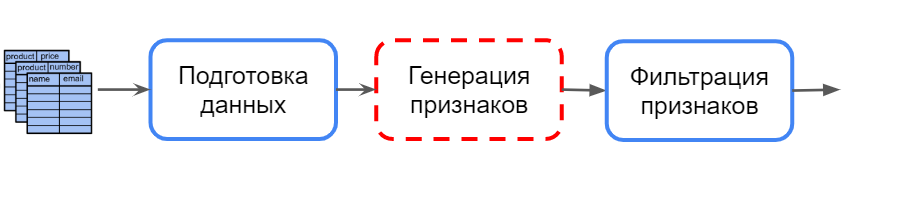</img>

### Несколько советов по `Feature Engineering`
    
<div class="alert alert-info">
    
- 🏁 Начинайте с сырых данных. 
- 🧩 Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- 🧠 Формулируйте предположения: от чего зависит таргет? 
- 🤔 Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- ⚠️ Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать. 

Теперь, полученные данные нам необходимо склеить вместе для наших машинных обучений. Ведь ML модели умеют работать только с одним датасетом за раз. Но у нас тут небольшой казус - в `car_train` все машины уникальны, а в `rides_info` для каждой машины указано множество поездок на ней. Ну что ж, давайте разберемся, как с этим справиться.

Вот что мы сделаем:

1. **Группировка данных**: Сначала возьмем датасет `rides_info` с информацией о поездках и разделим данные по каждой машинке отдельно.

2. **Считаем разные фичи**: Для каждой машины (то есть для каждого `car_id`) мы подсчитаем несколько интересных моментов:
   - Какой минимальный и средний рейтинг за все поездки.
   - Сколько всего километров проехала.
   - Какая была максимальная скорость.
   - Сколько всего поездок сделала каждая машина.
   - И добавьте еще минимум 3 фичи по своему вкусу.

3. **Соединим два датасета**: Вспомните про методы соединения таблиц и подумайте о том, какой применить в нашем случае


Результат этого шага запишите в переменную `df`

In [ ]:
# YOUR CODE HERE

Компания предоставила вам еще два набора данных для анализа. Вы можете использовать их, чтобы собрать больше признаков и улучшить качество модели

1. Информация про ремонт машин (`fix_info`)
2. Информация про водителей (`driver_info`)

<center> 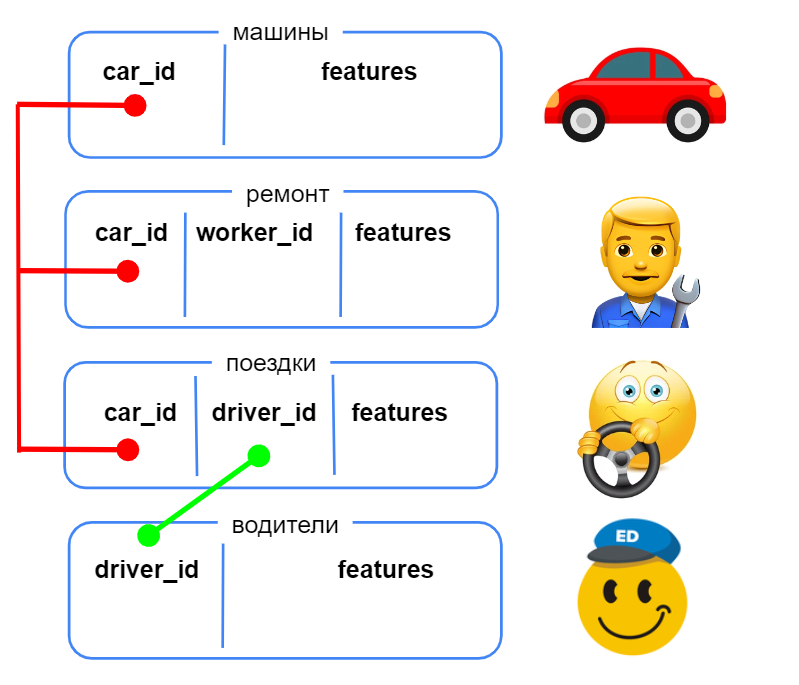 </img>>

In [ ]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')

In [ ]:
# YOUR CODE HERE

<div class="alert alert-info">

При желании, попробуйте сгенерировать некоторые из этих признаков. Подумайте, какие из них самые полезные?
    
* `feature_min_max_diff` : разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` : угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` : среднее значение `deviation_normal` для каждой машины
* `feature_shift` : точка перегиба/сдвига для `deviation_normal`
* `feature_start` : значение точки старта для `deviation_normal`
* `feature_nans`: сумма пропусков для столбца `...` для каждой машины 
* `feature_quant`: `X %` квантиль для столбца `...` для каждой машины 

### <center> Нагенерировали? А теперь будем убирать!

<center> 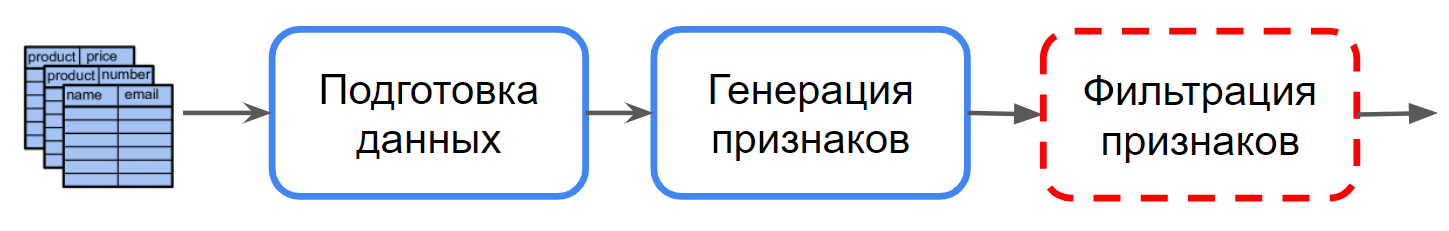</img>

<div class="alert alert-info">

<center> <b>Зачем вообще заниматься отбором признаков?</b> </center>
    
Основных причин несколько:
1. Если фичей очень много, то данные могут перестать помещаться в память, может существенно увеличиться время обучения модели, тем более если мы захотим протестировать несколько разных алгоритмов или ансамбль. Особенно, в условиях ограничения платформ на длительность одной сессии (в Kaggle 12 часов) и лимиты по потребляемой памяти.
2. Главная причина: с увеличением количества признаков часто падает точность предсказания модели. Особенно, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом). Некоторые алгоритмы при сильном увеличении числа признаков, вообще, перестают адекватно работать. И здравствуй, старый добрый оверфит!
3. Даже если точность не снижается, есть риск, что ваша модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.
</div>

### Несколько советов по `Feature Selection`
    
<div class="alert alert-info">
<b>Что можно удалить сразу?</b>
    
- Константы
- Уникальные значения (в том числе в тесте, как правило это ID-шники по типу `car_id`)
    
<b>Какие методы использовать дальше?</b>
- Линейная корреляция 📈
- Phik - тоже корреляция, но на стероидах 💪 ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7))
- 🧩 Permutation importance (из `scikit-learn`)
- SHAP values 🤼‍♀️ (из библиотеки `shap`)
- 😼 CatBoost Feature Selection (рекурсивные методы)
</div>

Попробуйте применить несколько методов и сделать выводы на их основе

In [ ]:
# YOUR CODE HERE

## <center>  2. Прогнозируем время и вид поломки машин - настраиваем ML модель.

Для начала классифицируем признаки на типы

In [ ]:
features2drop = [] # то, что надо выбросить
targets = [] # таргеты
cat_features = [] # категориальные признаки

num_features = [] # числовые признаки

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

Начнем с библиотеки [CatBoost](https://catboost.ai/en/docs/) (быстрее всего заводится, меньше неочевидных моментов, высокая точность с дефолтными параметрами) для построения модели классификации. Вам нужно будет выполнить следующие шаги:

1. Выделите в `X` только признаки, а в `y` таргет (для задачи классификации)

2. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость ваших результатов)

3. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно)

4. Проведите оценку вашей модели, используя метрику `accuracy`

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# YOUR CODE HERE

## <center>  3. Визуализация прогнозов, ошибок модели и важности признаков.

<div class="alert alert-info">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели
- Отсеять лишние признаки
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных



Визуализируйте важность фичей для `CatBoost` (но помните, что не стоит сильно доверять этому рейтингу важности, т.к. для сильно скоррелированных признаков важность делится пополам и оба признака могут улететь вниз по важности)


In [ ]:
# YOUR CODE HERE

`classification_report` и `confusion_matrix`. Построим сразу все метрики и посмотрим в каких классах модель больше всего ошибается с помощью матрицы смежности.

In [ ]:
# YOUR CODE HERE

## <center>  4. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`


<div class="alert alert-info">

Ключевые особенности `Optuna`:
- 🎯 Легковесность и универсальность - можно подбирать оптимальные параметры под любые функции и метрики
- 🎁 SOTA алгоритмы, адаптированные для поиска гиперпараметров
- ⏱ Параллелизация и различные методы прунинга
- 📈 Встроенная визуализация
- 🤝 Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие)

Чтобы понять, как ее использовать, давайте разберем ее по частям.

### В `Optuna` присутствуют 2 базовые сущности:

1. `Study`: оптимизация, базирующаяся на `Objective` функции.


В `Objective` функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optun'ой много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

2. `Trial` - одно выполнение `Objective` функции

В `trial` обьекте мы передаем параметры для "перебора", используя для каждого типа свой метод. К примеру

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы.
param = trial.suggest_float('param', 0, 1.5) 

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

### Study parameters

<div class="alert alert-info">

Инициализируем обьект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')` 
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` - самый популярный - дефолтный)
* `BruteForceSampler`
* И ещё [4 других](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers), также можно написать собственный сэмплер.

<div class="alert alert-info">

🌀 Советы по перебору параметров (очень логичные). 
- Иметь понимание важности параметров
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`
- Подсмотреть/чувствовать диапазоны и шаг значений
- Исключить то, что перебирать не нужно. (`random_seed` , `eval_metric`, `thread_count` и прочее)
- Используйте информацию с прошлых попыток

Напишите `objective` функцию и запустите `Optuna`, чтобы подобрать гиперпараметры для `CatBoostClassifier` 

In [ ]:
# YOUR CODE HERE

Посмотрите на полученные параметры, запустите обучение модели с ними и проверьте, улучшилось ли качество

In [ ]:
# YOUR CODE HERE

## <center>  5. Блендинг

> Одна голова хорошо, а `n` голов всё же лучше

Если на этапе построения первой модели (когда мы выбрали CatBoost) вы задались вопросом "А почему он, а не ~~я~~ `LightGBM` или `XGBoost` (или даже более простые модели)?", то сейчас вы можете построить всё, что пожелаете. А дальше, мы построим ансамбль этих моделей - блендинг. 

Самый простой способ сделать блендинг — это усреднить предсказания или взвесить ответы. 

<div class="alert alert-info">

* Основная идея блендинга - взять от каждого алгоритма лучшее и совместить несколько разных ML моделей в одну. 
* За счет такого объединения увеличивается обобщающая способность финальной модели и качество улучшается.
* Помимо этого, ваша модель становится более стабильной, что позволяет не слететь на приватном лидерборде.
* Особенно хорошо накидывает блендинг, если смешиваемые **модели имеют разную природу**: например, нейронные сети, KNN и решающие деревья, в этом случае они выучивают разные зависимости и хорошо дополняют друг друга.

На этом этапе вам нужно построить:
- `CatBoostClassifier`
- `LightGBMClassifier (goss)`.
- `XGBoostClassifier (dart)`.
- `RandomForestClassifier`
- (Дополнительно) любые модели по вашему желанию

Используйте все методы и приемы, которые знаете, чтобы улучшить итоговый скор

In [ ]:
# YOUR CODE HERE

Загрузим тестовый датасет и сделаем предсказание с помощью ансамбля моделей

> Не забудьте подготовить этот датасет, присоединить к нему информацию из других датасетов, добавить новые признаки. 

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')

In [ ]:
# YOUR CODE HERE

Для блендинга сохраните предсказания в соответствующие колонки (создайте их еще при необходимости)

In [ ]:
car_test['cb_pred'] = ...  # прогноз CatBoost
car_test['lgb_pred'] = ...  # прогноз lightGBM
car_test['xgb_pred'] = ...  # прогноз XgBoost
car_test['rf_pred'] = ... # прогноз RandomForest

Тогда, наконец, можно получить итоговое предсказание. Для задачи классификации есть два основных способа блендинга

1. `Hard Voting` - метод, при котором мы делаем голосование всех моделей и выбираем самый популярный класс.
2. `Soft Voting` - метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

Реализуйте оба варианта и сравните результаты

In [ ]:
final_pred = ...

Теперь, сохраните итоговое предсказание в `csv` файл со столбцами `car_id, target_class` и отправьте его в [соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview)

# <center>  6. Засылаем финальное решение на лидерборд на Kaggle